# Exploring the Uu RMS

### Steve Mairs

In this notebook, I will use pandas to explore the csv files produced by the Uu RMS python code written by 
Mark Rawlings and David Berry which queries the database to find Uu observations, then compares the ITC-calculated RMS to the ORACDR-measured RMS.

In [1]:
# Import Useful Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.stats import median_absolute_deviation
import datetime
plt.rcParams['figure.figsize'] = [7,5]
plt.rcParams['figure.dpi'] = 200 

**1. CSV File 1: Uu_RMS_table_20200721_to_20210729_excluding_20210529_to_20210709.csv:**

*All "Good" observations in this time range, excluding data obtained between 2021-05-29 and 2021-07-09, when the 3DB PADs were removed and TSYS values were high.*

**2. CSV File 2: Uu_RMS_table_20200721_to_20210729.csv:**

*All "Good" observations in this time range.*

These CSV files come from Mark Rawlings/David Berry's code (with my own modifications): Uu_RMS_comparison_v5.py

## User Inputs (Code Only - Removed from PDF)

In [30]:
csvfile            = 'Uu_RMS_table_20200721_to_20210729_with_elaptime.csv' # All Good Observations
csvfile_avoidrange = 'Uu_RMS_table_20200721_to_20210729_excluding_20210529_to_20210709_with_elaptime.csv' # All Good Observations
mindate_avoid = 20210529
maxdate_avoid = 20210709
mindate       = 20200721
maxdate       = 20210729
fudge_factor_cutoff = 20210401 #(inclusive) -- The earleist time we want to include to calculate fudge factors
int_time_or_elapsed_time = 'elapsed_time' # 'elapsed_time' is preferred! other option (not preferred) = 'int_time'

In [3]:
# Read in the data
Uu_df_all       = pd.read_csv(csvfile)
Uu_df_all_avoid = pd.read_csv(csvfile_avoidrange)

# Exclude data that is marked as shift "OTHER"
Uu_df       = Uu_df_all[np.logical_or(Uu_df_all['oper_sft'] == 'NIGHT',Uu_df_all['oper_sft'] == 'EO')]
Uu_df_avoid = Uu_df_all_avoid[np.logical_or(Uu_df_all_avoid['oper_sft']=='NIGHT',Uu_df_all_avoid['oper_sft']=='EO')]

In [4]:
# List of all columns
#for eachcol in Uu_df.columns.to_list():
#    print(eachcol)

In [5]:
# Define two different dataframes for the Good Dates and the Bad Dates:
Uu_df_baddates  = Uu_df[np.logical_and(Uu_df['utdate']>=mindate_avoid,Uu_df['utdate']<=maxdate_avoid)]
Uu_df_gooddates = Uu_df_avoid[np.logical_and(Uu_df_avoid['utdate']>=mindate,
                                             Uu_df_avoid['utdate']<=maxdate)]

In [6]:
# Cast date_obs to a datetime64 object
Uu_df_baddates['date_obs']       = pd.to_datetime(Uu_df_baddates['date_obs'], format='%Y-%m-%d %H:%M:%S')
Uu_df_gooddates['date_obs']      = pd.to_datetime(Uu_df_gooddates['date_obs'], format='%Y-%m-%d %H:%M:%S')

/Users/smairs/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Remove Bad Tsys

Right off the bat, lets just remove bad Tsys values. 

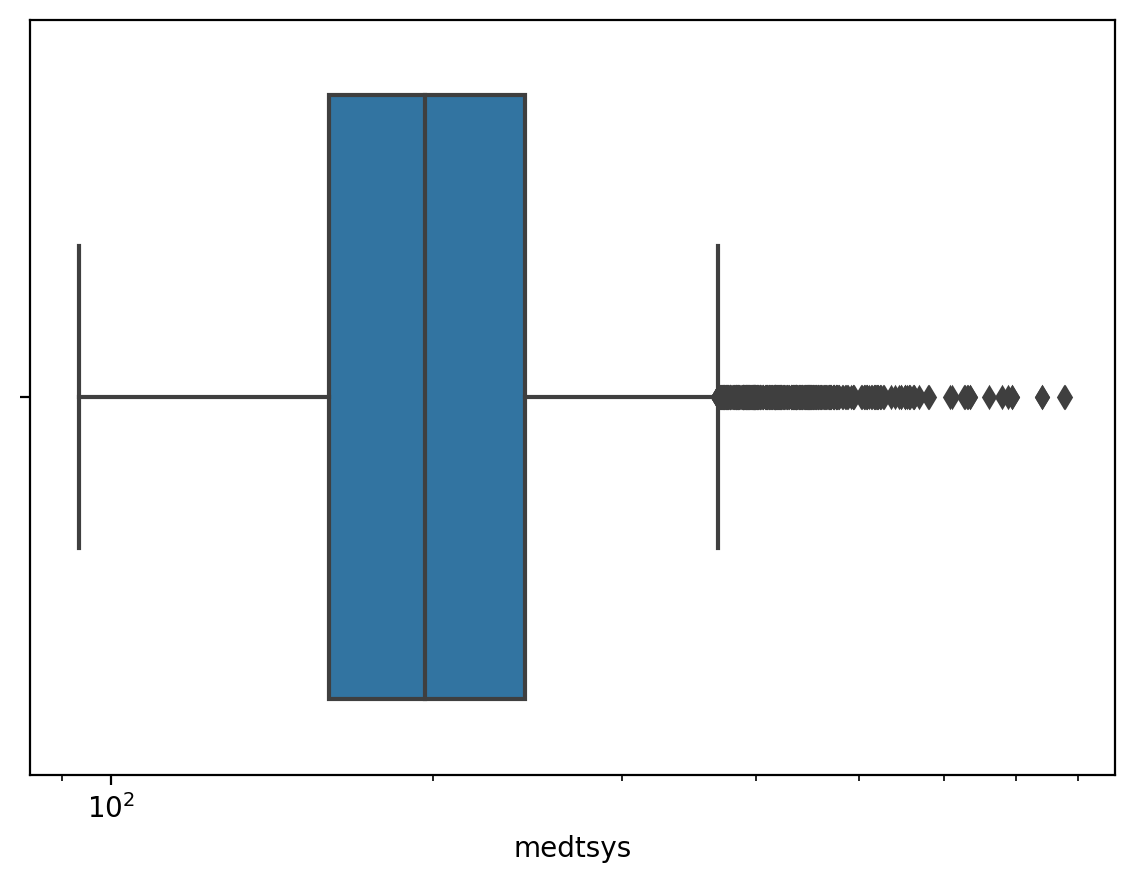

<Figure size 1400x1000 with 0 Axes>

In [7]:
sns.boxplot(Uu_df_gooddates['medtsys'])
plt.xscale('log')
plt.show()
plt.clf()

From the figure, above, it seems like 1.5* the 75th percentile extends to about **medtsys = 400 K**. So we'll draw our cutoff there.

In [8]:
medtsys_thresh = 400
Uu_df_baddates  = Uu_df_baddates[Uu_df_baddates['medtsys']<medtsys_thresh]
Uu_df_gooddates = Uu_df_gooddates[Uu_df_gooddates['medtsys']<medtsys_thresh]

## RMS Ratio Over Time Grouped By Observing Mode

"Bad Dates" are plotted in <span style="color:red">Red</span>.

In [9]:
# First, make sure we are dealing with the proper rms ratio (elapsed time is preferred but int_time is an option)
if int_time_or_elapsed_time == 'int_time':
    rmsratio_string = 'rmsratio_int'
else:
    rmsratio_string = 'rmsratio_elapsed'

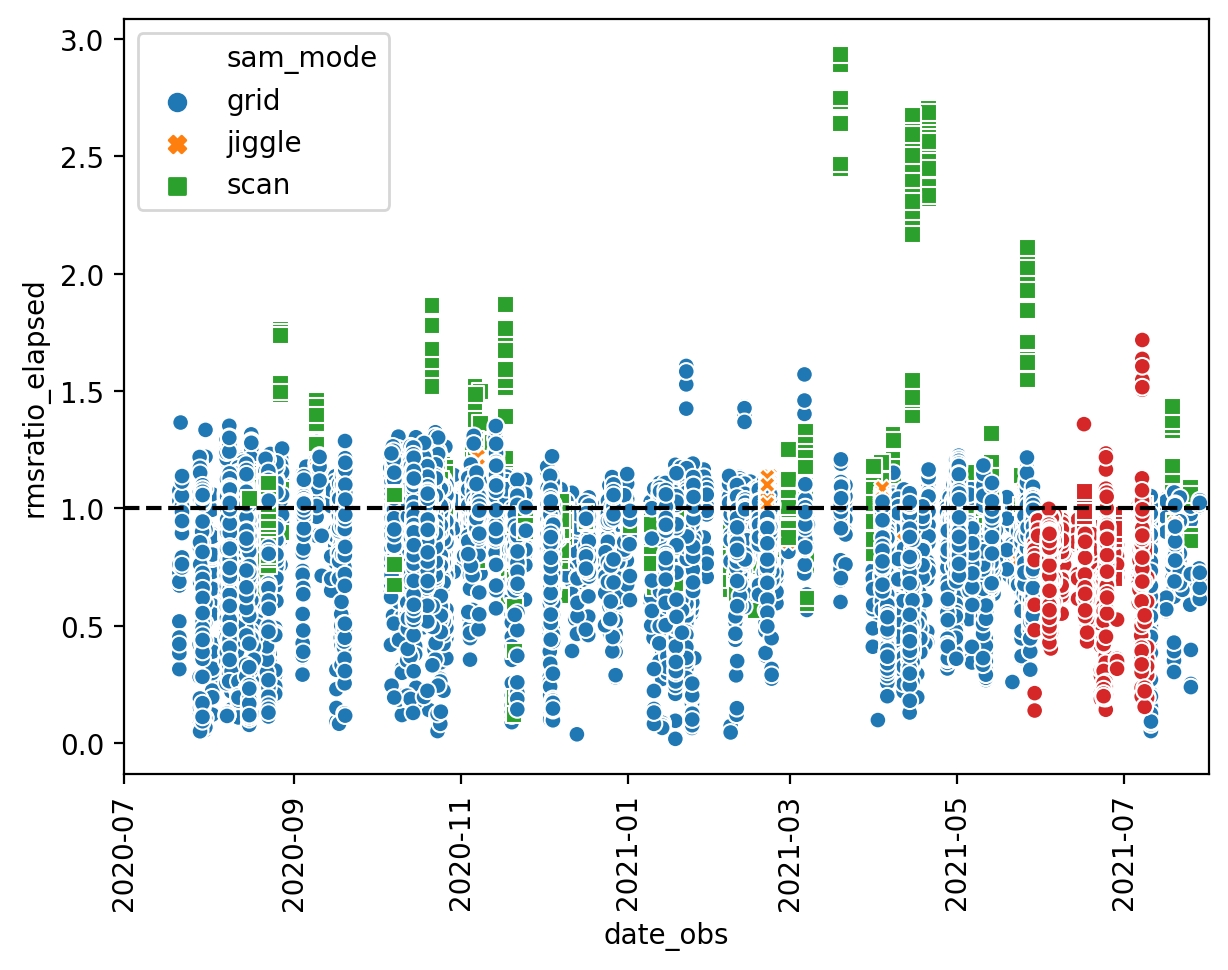

In [10]:
sns.scatterplot(x='date_obs',y=rmsratio_string,data=Uu_df_gooddates,hue='sam_mode',style='sam_mode')
sns.scatterplot(x='date_obs',y=rmsratio_string,data=Uu_df_baddates,color='tab:red',style='sam_mode', legend=False)
plt.xlim(datetime.date(2020,7,1),datetime.date(2021,8,1))
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.axhline(y=1.0,color='k',linestyle='dashed')
plt.show()

### Bin the data now by month so trends are easier to see -- use the median value when grouping by month

First, we will make a separate dataframe for each sam_mode so we can work with them individually (CODE REMOVED FROM PDF)

In [11]:
Uu_df_gooddates_jiggles = Uu_df_gooddates[Uu_df_gooddates['sam_mode'] == 'jiggle']
Uu_df_gooddates_grids   = Uu_df_gooddates[Uu_df_gooddates['sam_mode'] == 'grid']
Uu_df_gooddates_scans   = Uu_df_gooddates[Uu_df_gooddates['sam_mode'] == 'scan']
Uu_df_badddates_jiggles = Uu_df_baddates[Uu_df_baddates['sam_mode'] == 'jiggle']
Uu_df_baddates_grids    = Uu_df_baddates[Uu_df_baddates['sam_mode'] == 'grid']
Uu_df_baddates_scans    = Uu_df_baddates[Uu_df_baddates['sam_mode'] == 'scan']

Next, we will group the data by month for each sam_mode (CODE REMOVED FROM PDF)

In [12]:
Uu_df_baddates_jiggles_bymonth  = Uu_df_badddates_jiggles.groupby(pd.Grouper(key='date_obs', freq='M')).median()
Uu_df_gooddates_jiggles_bymonth = Uu_df_gooddates_jiggles.groupby(pd.Grouper(key='date_obs', freq='M')).median()

Uu_df_baddates_grids_bymonth    = Uu_df_baddates_grids.groupby(pd.Grouper(key='date_obs', freq='M')).median()
Uu_df_gooddates_grids_bymonth   = Uu_df_gooddates_grids.groupby(pd.Grouper(key='date_obs', freq='M')).median()

Uu_df_baddates_scans_bymonth    = Uu_df_baddates_scans.groupby(pd.Grouper(key='date_obs', freq='M')).median()
Uu_df_gooddates_scans_bymonth   = Uu_df_gooddates_scans.groupby(pd.Grouper(key='date_obs', freq='M')).median()

Of course, now we don't have date_obs in our key - but we still have UT date - so we can plot by the median UT date. To make this look a little better though, we will first convert to MJD so we don't have big gaps in the integers (CODE REMOVED FROM PDF)

In [13]:
# Jiggles
Uu_df_baddates_jiggles_bymonth_mjds = [Time(str(i)[0:4]+'-'+
                                     str(i)[4:6]+'-'+
                                     str(i)[6:8]+'T00:00:00.00',
                                     format='isot').mjd if not np.isnan(i) else i 
                                for i in Uu_df_baddates_jiggles_bymonth['utdate']]
Uu_df_gooddates_jiggles_bymonth_mjds = [Time(str(i)[0:4]+'-'+
                                     str(i)[4:6]+'-'+
                                     str(i)[6:8]+'T00:00:00.00',
                                     format='isot').mjd if not np.isnan(i) else i 
                                for i in Uu_df_gooddates_jiggles_bymonth['utdate']]
# Grids
Uu_df_baddates_grids_bymonth_mjds = [Time(str(i)[0:4]+'-'+
                                     str(i)[4:6]+'-'+
                                     str(i)[6:8]+'T00:00:00.00',
                                     format='isot').mjd if not np.isnan(i) else i 
                                for i in Uu_df_baddates_grids_bymonth['utdate']]
Uu_df_gooddates_grids_bymonth_mjds = [Time(str(i)[0:4]+'-'+
                                     str(i)[4:6]+'-'+
                                     str(i)[6:8]+'T00:00:00.00',
                                     format='isot').mjd if not np.isnan(i) else i 
                                for i in Uu_df_gooddates_grids_bymonth['utdate']]
# Scans
Uu_df_baddates_scans_bymonth_mjds = [Time(str(i)[0:4]+'-'+
                                     str(i)[4:6]+'-'+
                                     str(i)[6:8]+'T00:00:00.00',
                                     format='isot').mjd if not np.isnan(i) else i 
                                for i in Uu_df_baddates_scans_bymonth['utdate']]
Uu_df_gooddates_scans_bymonth_mjds = [Time(str(i)[0:4]+'-'+
                                     str(i)[4:6]+'-'+
                                     str(i)[6:8]+'T00:00:00.00',
                                     format='isot').mjd if not np.isnan(i) else i 
                                for i in Uu_df_gooddates_scans_bymonth['utdate']]

Next, calculate the median rms ratios (the *fudge factors*) since the fudge_factor_cutoff, excluding the bad dates, for each sam_mode 

(CODE REMOVED FROM PDF)

In [14]:
# Jiggles fudge factors
jigglefactor     = round(np.nanmedian(Uu_df_gooddates_jiggles[rmsratio_string][Uu_df_gooddates_jiggles['utdate'] >=
                                                                          fudge_factor_cutoff]),2)
jigglefactor_err = round(100*median_absolute_deviation(Uu_df_gooddates_jiggles[rmsratio_string][
                                                           Uu_df_gooddates_jiggles['utdate'] >= fudge_factor_cutoff],
                                                       nan_policy='omit'),1)
# Grids fudge factors
gridfactor     = round(np.nanmedian(Uu_df_gooddates_grids[rmsratio_string][Uu_df_gooddates_grids['utdate'] >=
                                                                      fudge_factor_cutoff]),2)
gridfactor_err = round(100*median_absolute_deviation(Uu_df_gooddates_grids[rmsratio_string][
                                                         Uu_df_gooddates_grids['utdate'] >= fudge_factor_cutoff],
                                                     nan_policy='omit'),1)
# Scans fudge factors
scanfactor     = round(np.nanmedian(Uu_df_gooddates_scans[rmsratio_string][Uu_df_gooddates_scans['utdate'] >=
                                                                      fudge_factor_cutoff]),2)
scanfactor_err = round(100*median_absolute_deviation(Uu_df_gooddates_scans[rmsratio_string][
                                                         Uu_df_gooddates_scans['utdate'] >= fudge_factor_cutoff],
                                                     nan_policy='omit'),1)

Next we can make a plot with pyplot! The fudge factors are given in the legend and also below.

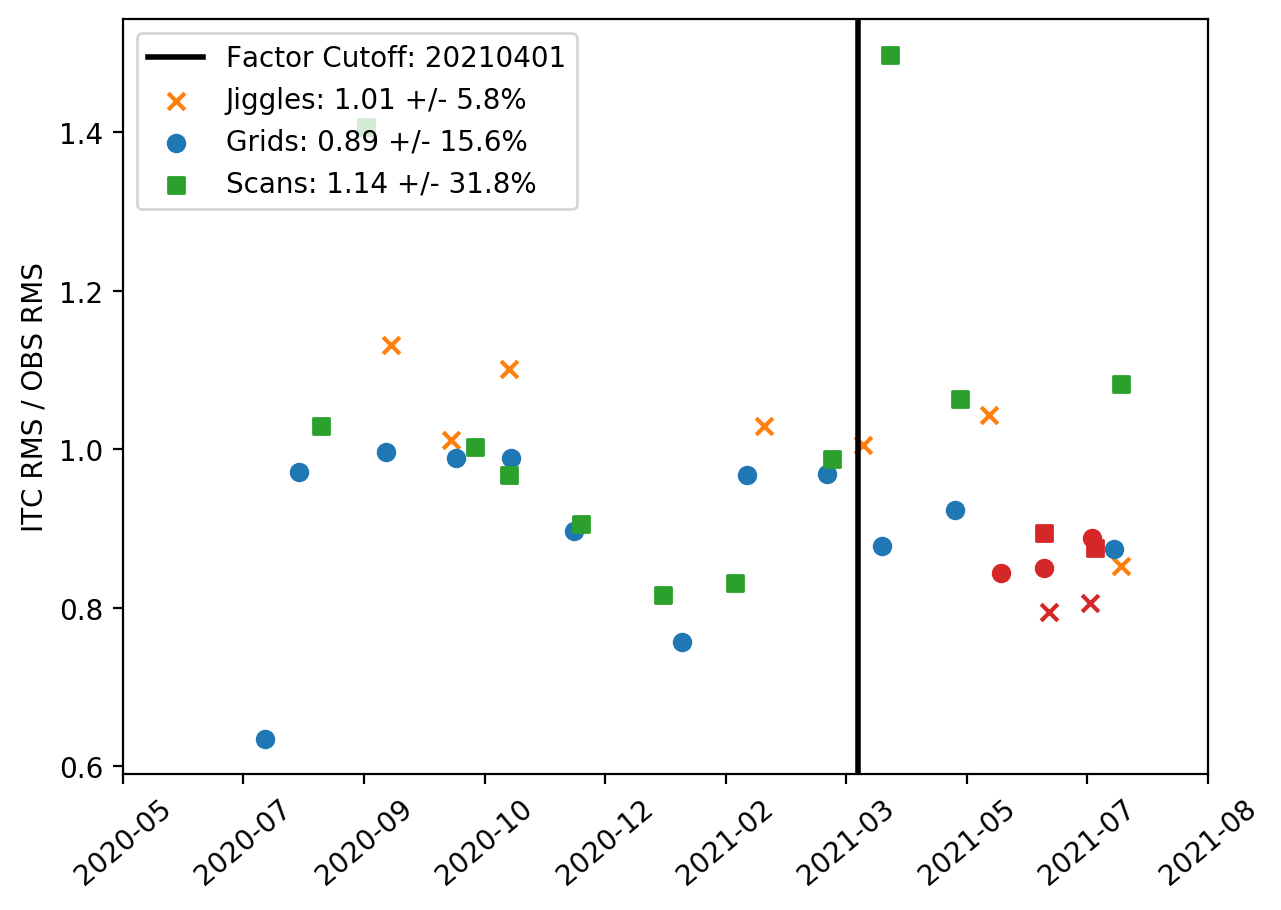

<Figure size 1400x1000 with 0 Axes>

In [31]:
# Jiggles
plt.scatter(Uu_df_gooddates_jiggles_bymonth_mjds, Uu_df_gooddates_jiggles_bymonth[rmsratio_string],
            color='tab:orange', marker='x', label='Jiggles: {} +/- {}%'.format(jigglefactor,jigglefactor_err))
plt.scatter(Uu_df_baddates_jiggles_bymonth_mjds, Uu_df_baddates_jiggles_bymonth[rmsratio_string],
            color='tab:red', marker='x')
# Grids
plt.scatter(Uu_df_gooddates_grids_bymonth_mjds, Uu_df_gooddates_grids_bymonth[rmsratio_string],
            color='tab:blue', marker='o', label='Grids: {} +/- {}%'.format(gridfactor,gridfactor_err))
plt.scatter(Uu_df_baddates_grids_bymonth_mjds, Uu_df_baddates_grids_bymonth[rmsratio_string],
            color='tab:red', marker='o')
#Scans
plt.scatter(Uu_df_gooddates_scans_bymonth_mjds, Uu_df_gooddates_scans_bymonth[rmsratio_string],
            color='tab:green', marker='s', label='Scans: {} +/- {}%'.format(scanfactor,scanfactor_err))
plt.scatter(Uu_df_baddates_scans_bymonth_mjds, Uu_df_baddates_scans_bymonth[rmsratio_string],
            color='tab:red', marker='s')
#
plt.axvline(x=Time(str(fudge_factor_cutoff)[0:4]+'-'+
                   str(fudge_factor_cutoff)[4:6]+'-'+
                   str(fudge_factor_cutoff)[6:8]+'T00:00:00.00',format='isot').mjd,
            linewidth=2,linestyle='solid',color='k',
            label='Factor Cutoff: {}'.format(fudge_factor_cutoff))
xticks = plt.xticks()[0]
xticklabels = []
for i in xticks:
    isodate = str(Time(i,format='mjd').isot)
    year = isodate.split('-')[0]
    month = isodate.split('-')[1]
    xticklabels.append(year+'-'+month)
plt.xticks(xticks,xticklabels,rotation=40)
plt.ylabel('ITC RMS / OBS RMS')
plt.legend(loc='upper left')
plt.show()
plt.clf()

**We see a 10% decrease in scan value during the 3DB PAD removal**

## Fudge Factors Calculated since 2021-04-01

In [16]:
print('Jiggles: {} +/- {}%'.format(jigglefactor,jigglefactor_err))
print('Grids  : {} +/- {}%'.format(gridfactor,gridfactor_err))
print('Scans  : {} +/- {}%'.format(scanfactor,scanfactor_err))

Jiggles: 1.01 +/- 5.8%
Grids  : 0.89 +/- 15.6%
Scans  : 1.14 +/- 31.8%


#### Fudge Factor =  ITC RMS / OBS RMS

**Jiggles**: 1.01 +/- 5.8%

**Grids**  : 0.89 +/- 15.6%

**Scans**  : 1.14 +/- 31.8%

Calculated by the median *rmsratio* value since 2021-04-01 (excluding 2021-05-29 to 2021-07-09). Errors are the median absolute deviation.

## Transmission

Now we'll take a look at the *rmsratio* as a function of atmospheric transmission.

In [17]:
# First define transmission columns:

avg_tau_gooddates = (Uu_df_gooddates['wvmtaust']+Uu_df_gooddates['wvmtauen'])/2.0
avg_am_gooddates  = (Uu_df_gooddates['amstart']+Uu_df_gooddates['amend'])/2.0
Uu_df_gooddates['Transmission'] = 100*np.exp(-avg_tau_gooddates*avg_am_gooddates)

avg_tau_baddates = (Uu_df_baddates['wvmtaust']+Uu_df_baddates['wvmtauen'])/2.0
avg_am_baddates  = (Uu_df_baddates['amstart']+Uu_df_baddates['amend'])/2.0
Uu_df_baddates['Transmission'] = 100*np.exp(-avg_tau_baddates*avg_am_baddates)

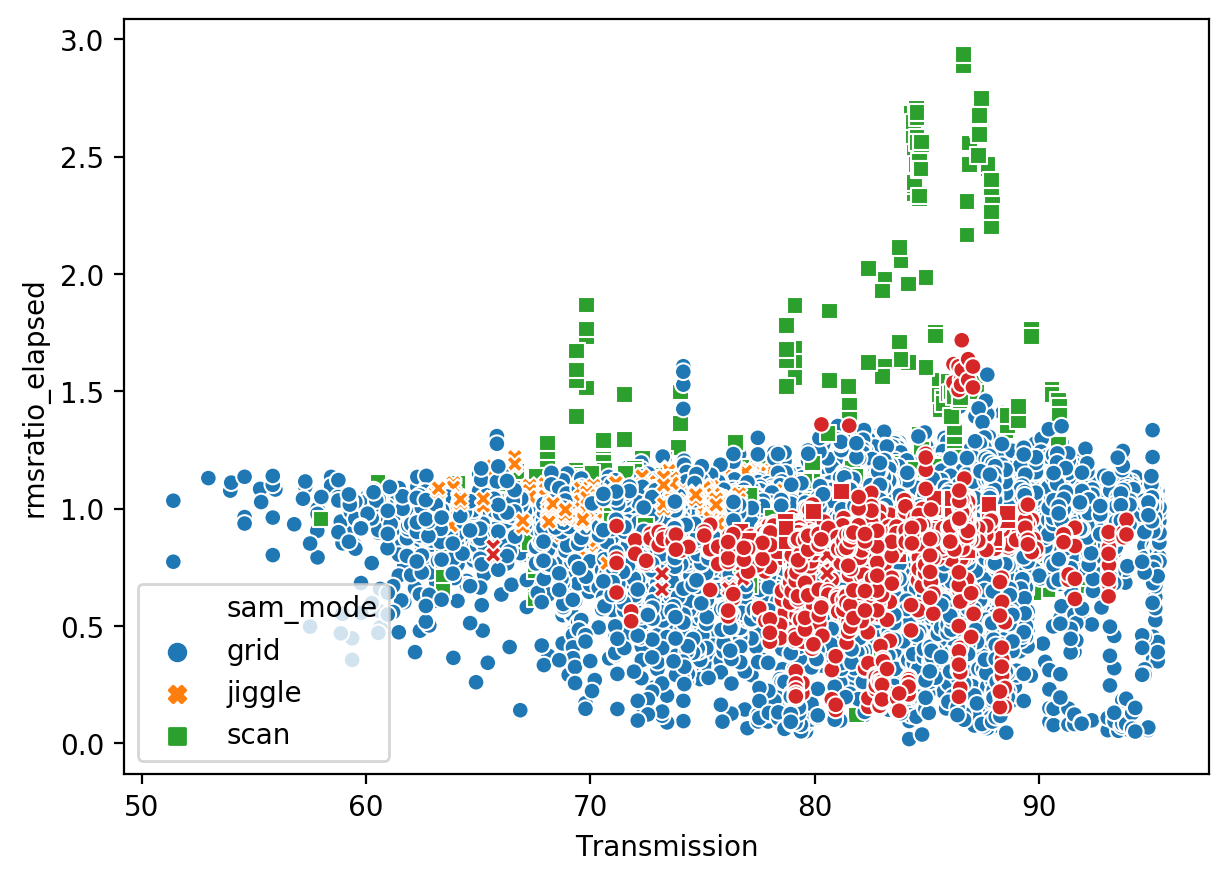

In [18]:
sns.scatterplot(x='Transmission',y=rmsratio_string,data=Uu_df_gooddates,hue='sam_mode',style='sam_mode')
sns.scatterplot(x='Transmission',y=rmsratio_string,data=Uu_df_baddates,color='tab:red',style='sam_mode', legend=False)
plt.legend(loc='lower left')
plt.show()

Separate this out by binning the transmission into 5 weather bins and plot by *sam_mode*

In [19]:
trans_bins = [25,40,55,70,85,100]
group_names = ['Very Poor','Poor','Average','Good','Very Good']

In [20]:
Uu_df_baddates['Trans-binned']  = pd.cut(Uu_df_baddates['Transmission'],
                                         trans_bins,labels=group_names,include_lowest=False)
Uu_df_gooddates['Trans-binned'] = pd.cut(Uu_df_gooddates['Transmission'],
                                         trans_bins,labels=group_names,include_lowest=False)

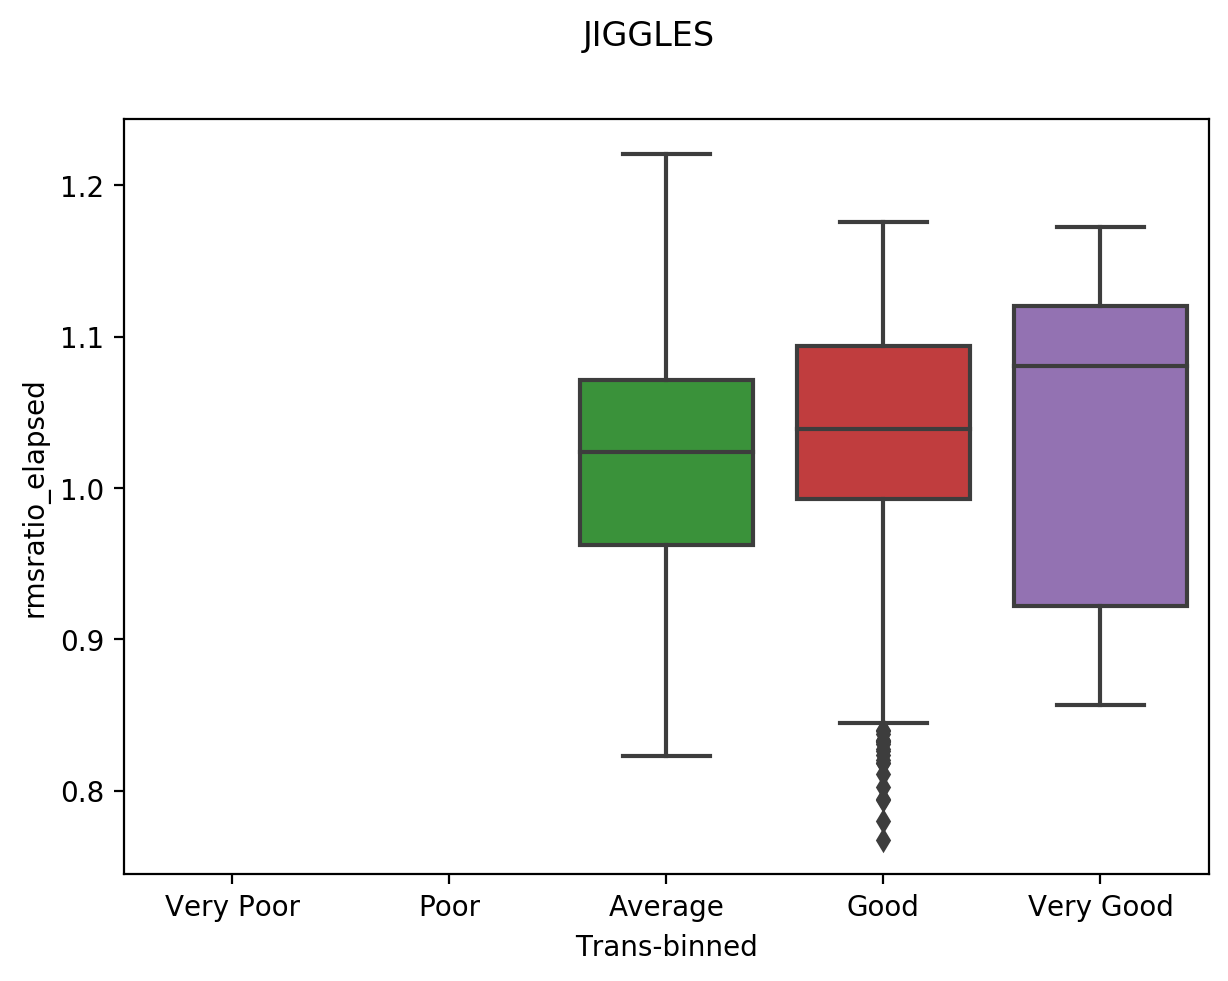

<Figure size 1400x1000 with 0 Axes>

In [21]:
# Jiggles
sns.boxplot(x='Trans-binned', y=rmsratio_string, data=Uu_df_gooddates[Uu_df_gooddates['sam_mode']=='jiggle'])
plt.suptitle('JIGGLES')
plt.show()
plt.clf()

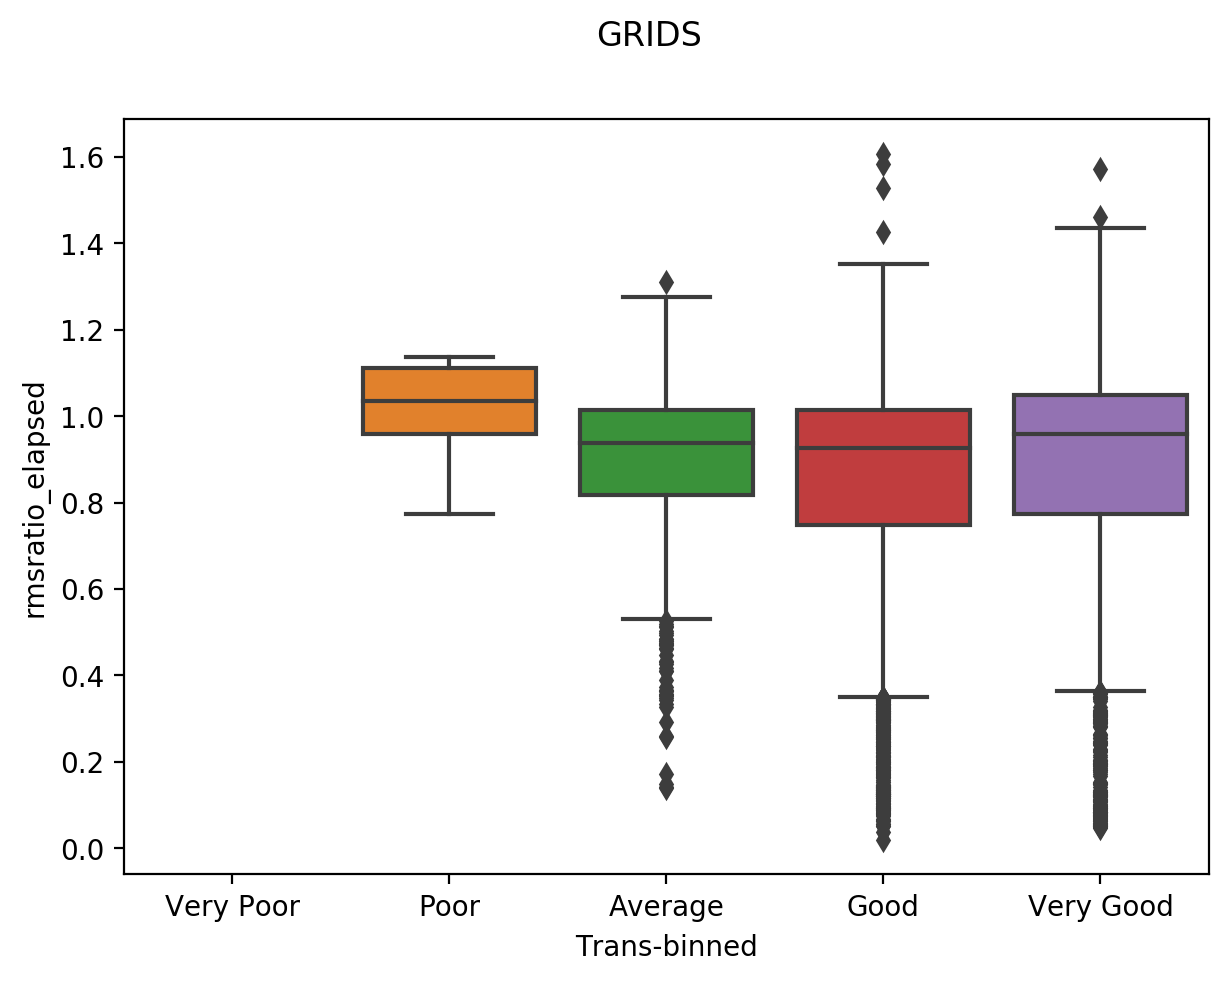

<Figure size 1400x1000 with 0 Axes>

In [22]:
# Grids
sns.boxplot(x='Trans-binned', y=rmsratio_string, data=Uu_df_gooddates[Uu_df_gooddates['sam_mode']=='grid'])
plt.suptitle('GRIDS')
plt.show()
plt.clf()

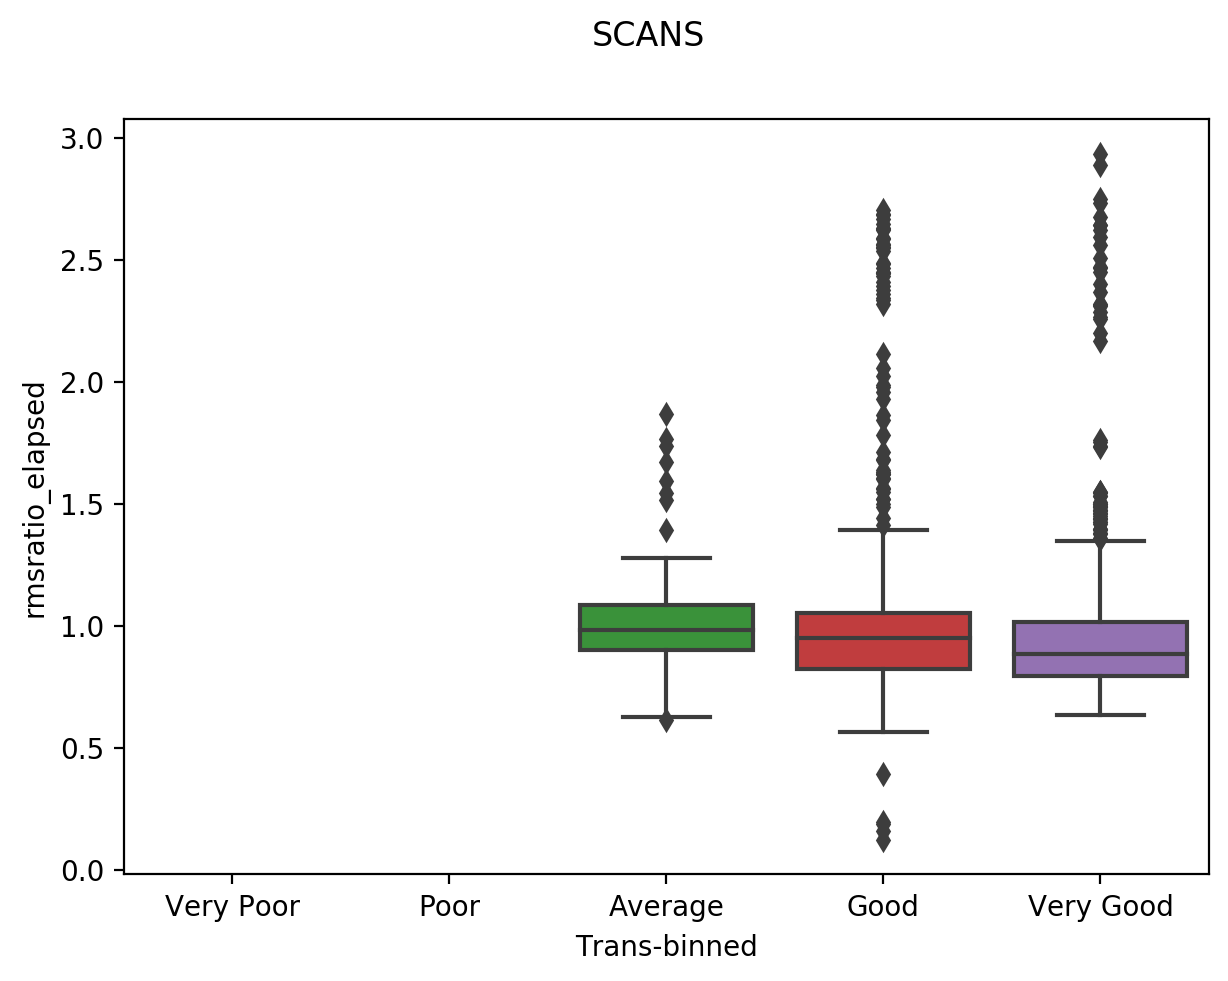

<Figure size 1400x1000 with 0 Axes>

In [23]:
# Scans
sns.boxplot(x='Trans-binned', y=rmsratio_string, data=Uu_df_gooddates[Uu_df_gooddates['sam_mode']=='scan'])
plt.suptitle('SCANS')
plt.show()
plt.clf()

## Plot by Sky Frequency

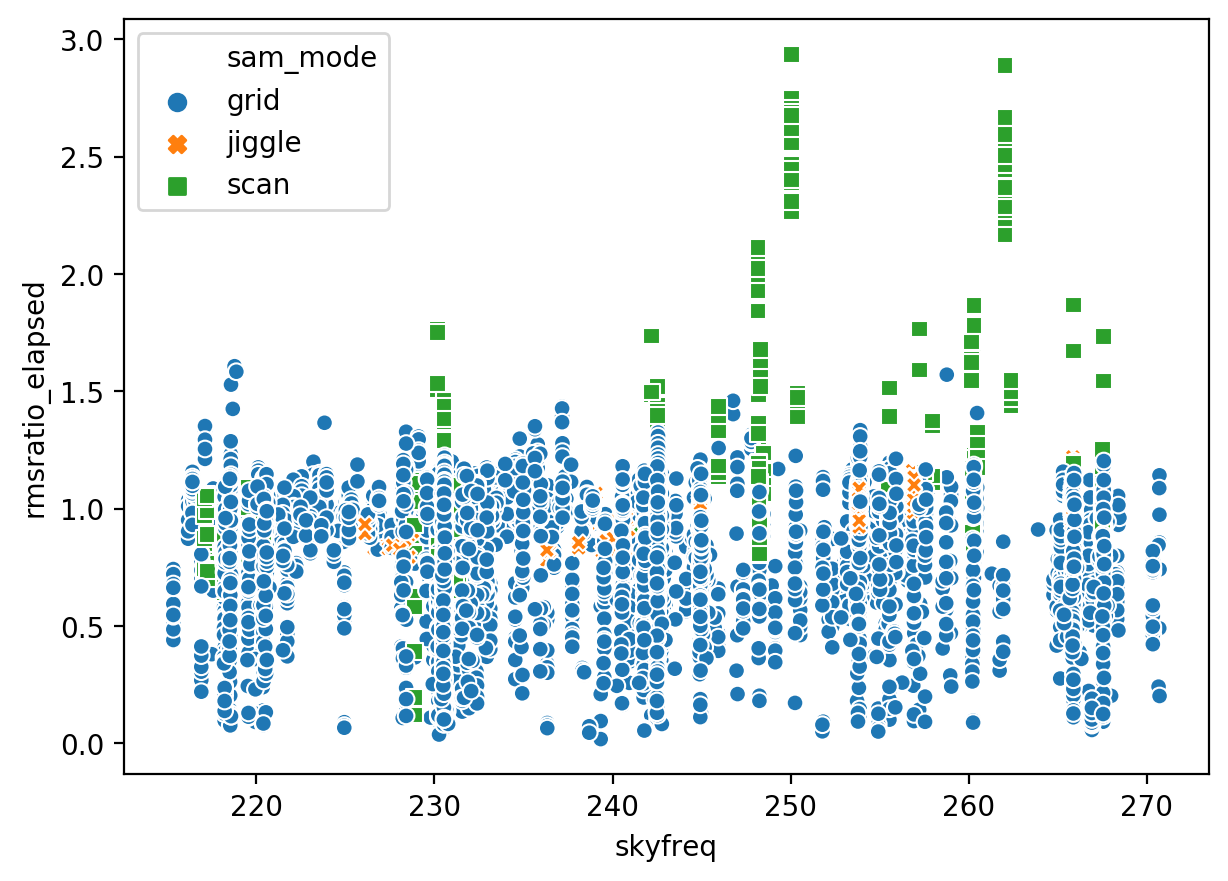

In [32]:
sns.scatterplot(x='skyfreq',y=rmsratio_string,data=Uu_df_gooddates,hue='sam_mode',style='sam_mode')
#sns.scatterplot(x='skyfreq',y=rmsratio_string,data=Uu_df_baddates,color='tab:red',style='sam_mode', legend=False)
plt.legend(loc='upper left')
plt.show()

## Plot by IF Freq

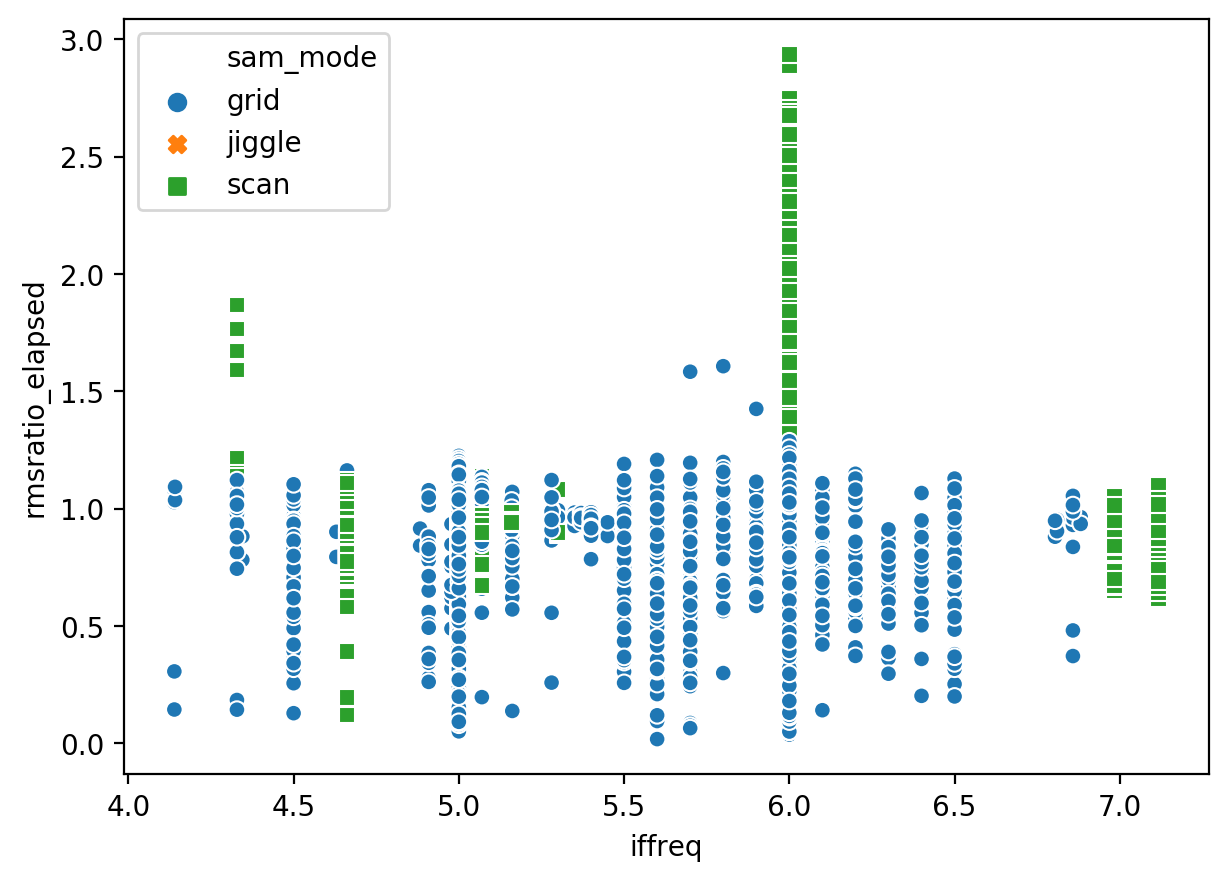

In [33]:
sns.scatterplot(x='iffreq',y=rmsratio_string,data=Uu_df_gooddates,hue='sam_mode',style='sam_mode')
#sns.scatterplot(x='skyfreq',y=rmsratio_string,data=Uu_df_baddates,color='tab:red',style='sam_mode', legend=False)
plt.legend(loc='upper left')
plt.show()

## Plot by BW Mode

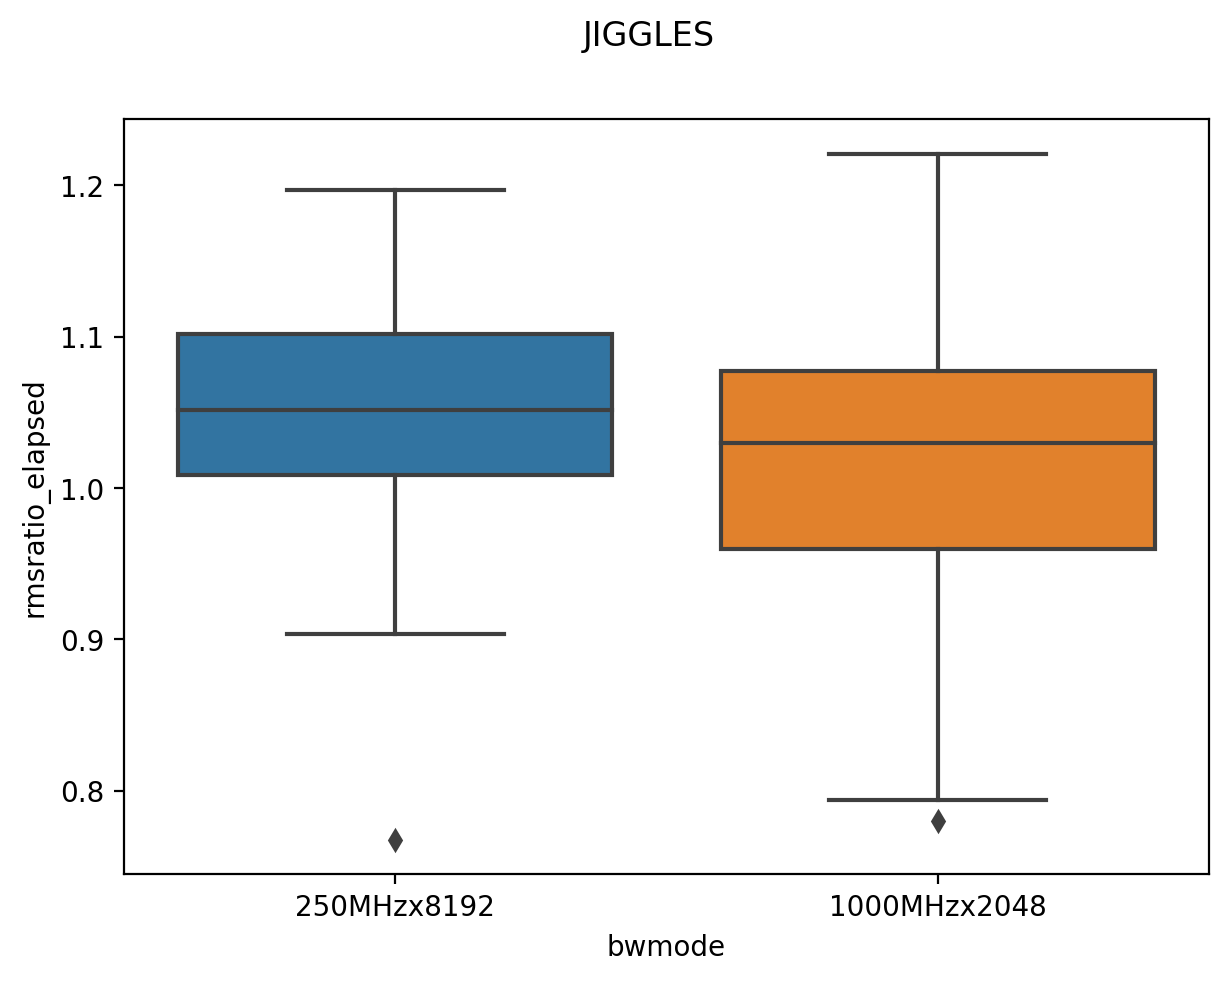

<Figure size 1400x1000 with 0 Axes>

In [26]:
# Jiggles

sns.boxplot(x='bwmode', y=rmsratio_string, data=Uu_df_gooddates[Uu_df_gooddates['sam_mode']=='jiggle'])
plt.suptitle('JIGGLES')
plt.show()
plt.clf()

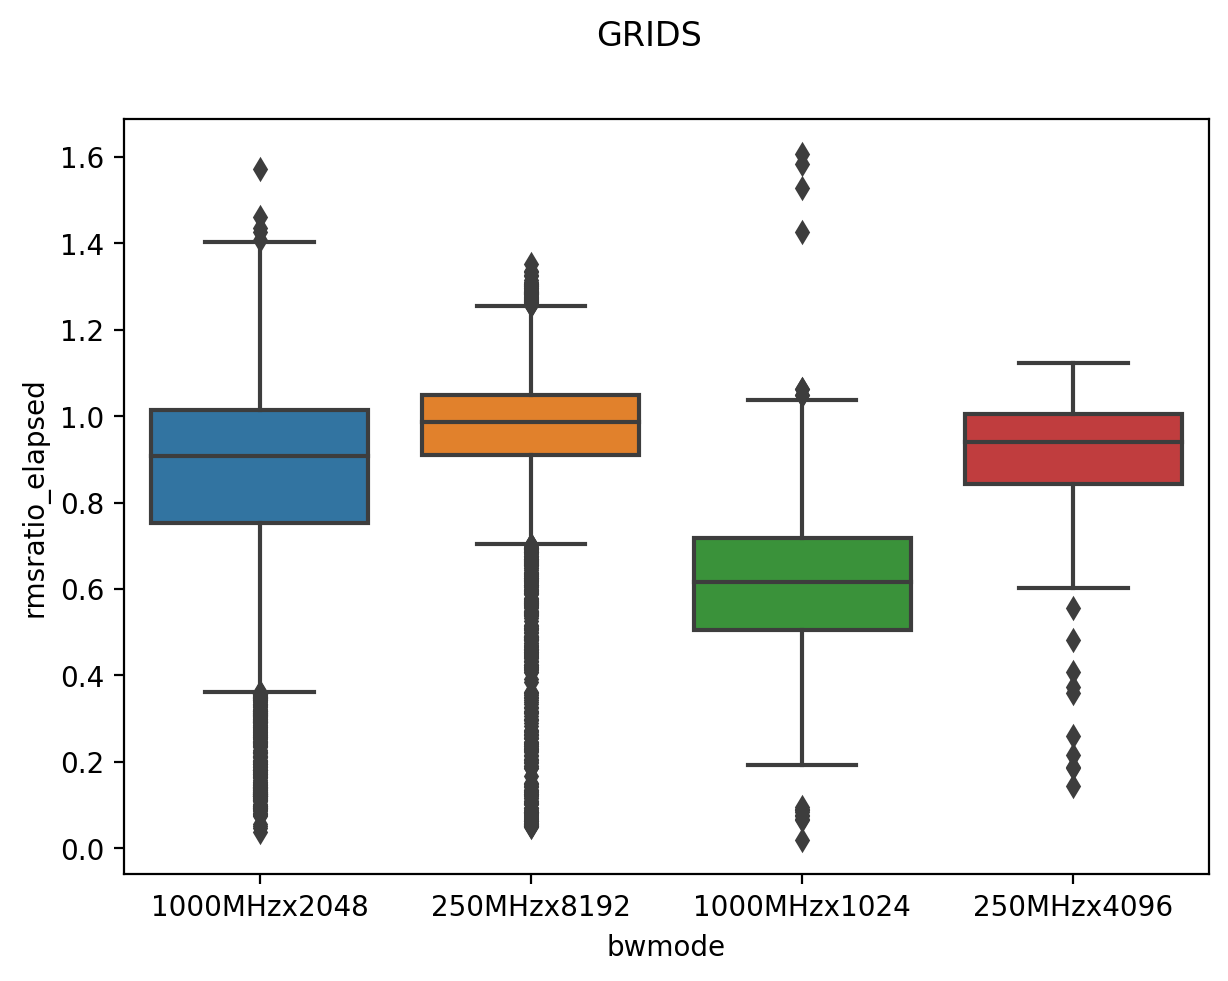

<Figure size 1400x1000 with 0 Axes>

In [27]:
# Grids

sns.boxplot(x='bwmode', y=rmsratio_string, data=Uu_df_gooddates[Uu_df_gooddates['sam_mode']=='grid'])
plt.suptitle('GRIDS')
plt.show()
plt.clf()

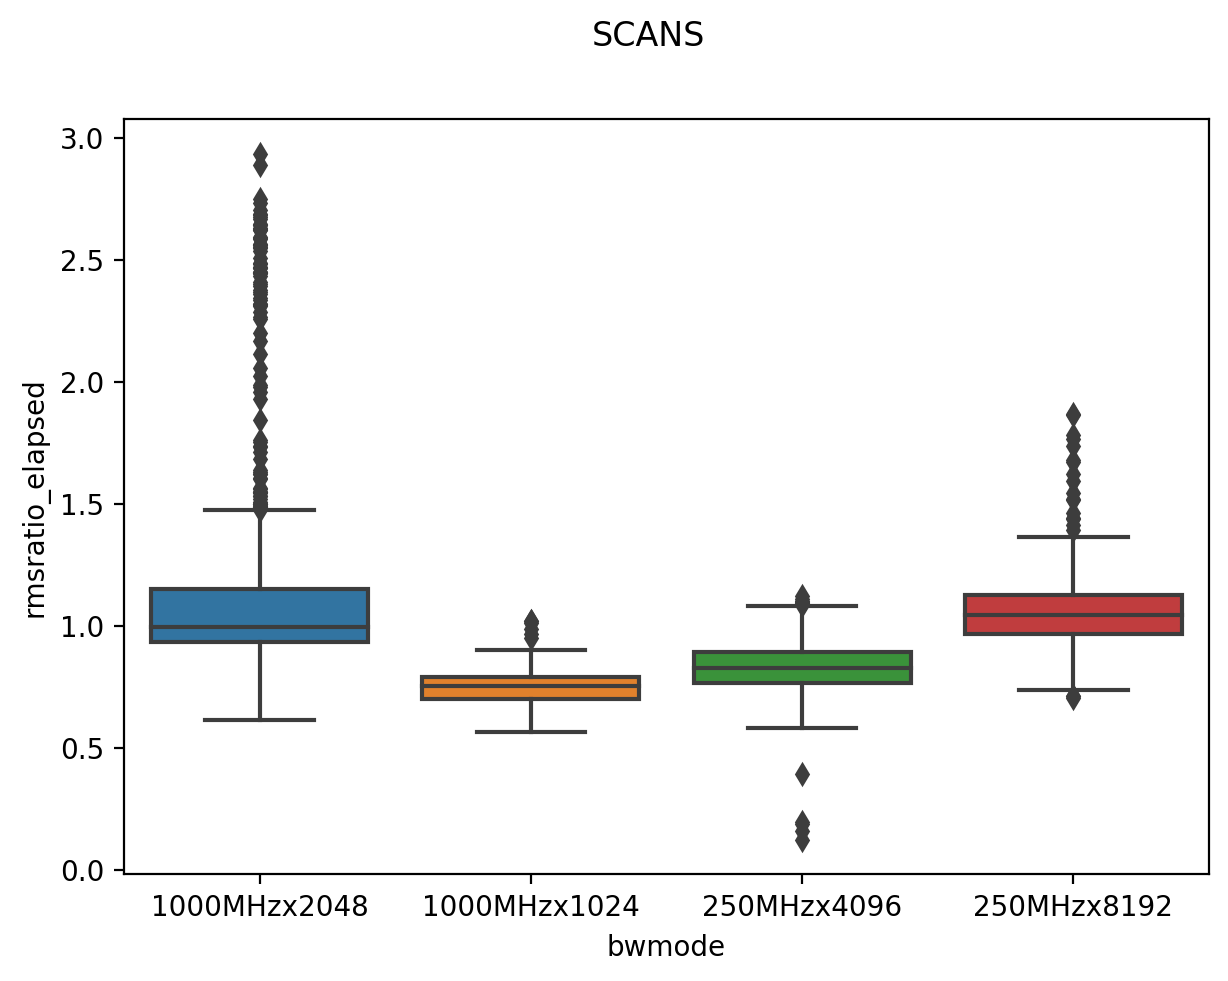

<Figure size 1400x1000 with 0 Axes>

In [28]:
# Scans

sns.boxplot(x='bwmode', y=rmsratio_string, data=Uu_df_gooddates[Uu_df_gooddates['sam_mode']=='scan'])
plt.suptitle('SCANS')
plt.show()
plt.clf()

## Correlation Heatmap of the most important features for rmsratio

The graph below shows the pearson r correlation between parameters. Along the rmsratio row - nothing in particular sticks out as having a strong trend other than perhaps Airmass (as gauged quickly by a linear fit).

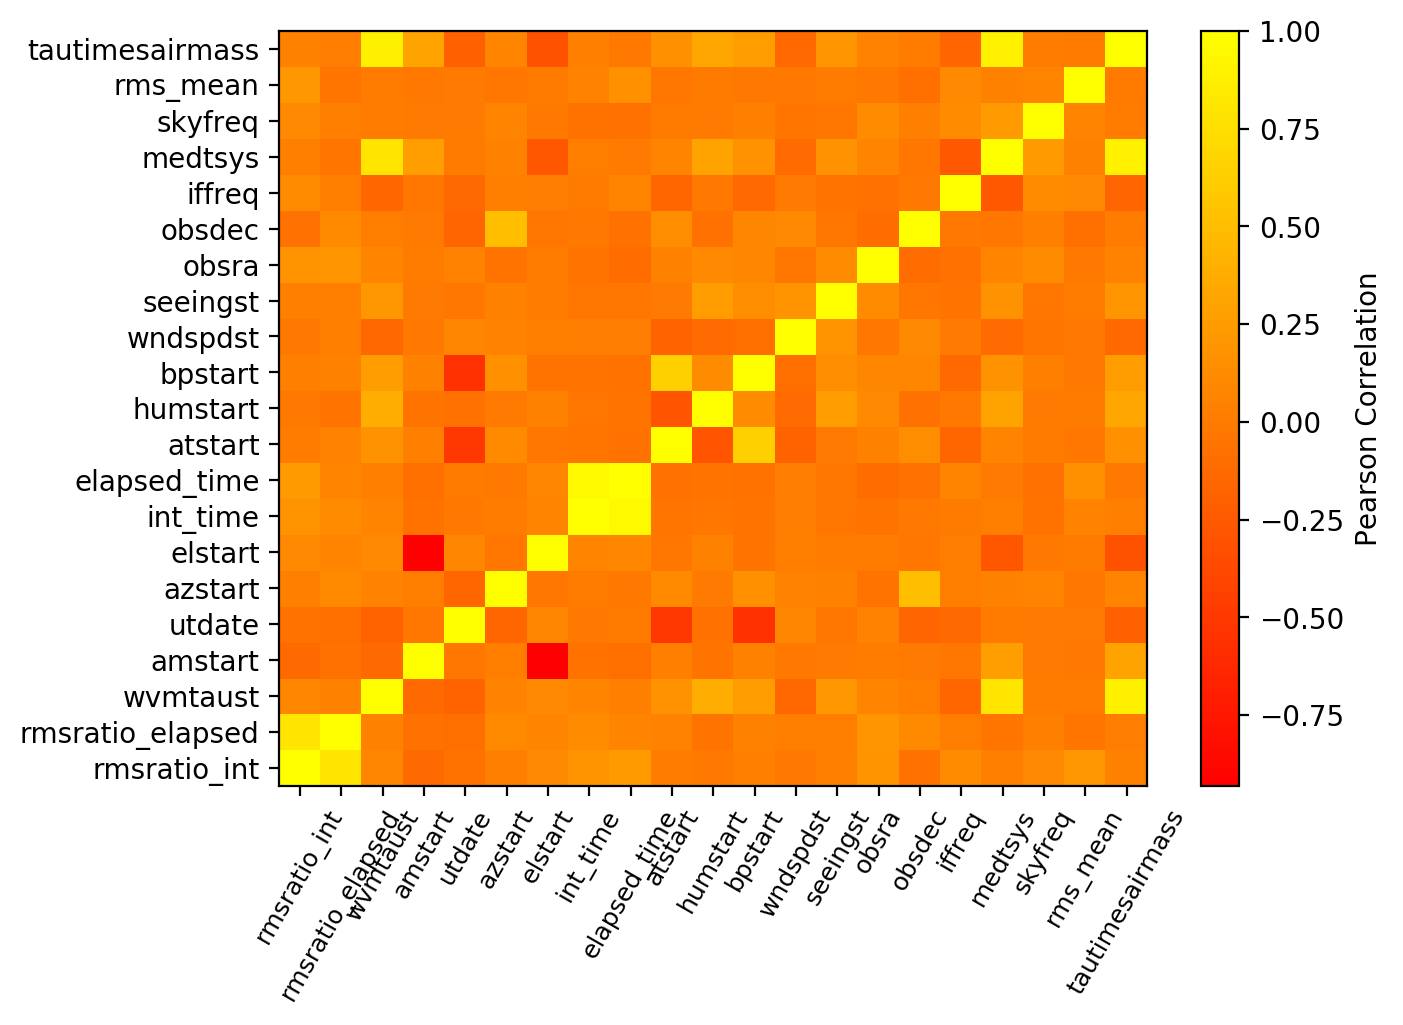

<Figure size 1400x1000 with 0 Axes>

In [34]:
fig, ax = plt.subplots()
df_corr = Uu_df_gooddates[['rmsratio_int','rmsratio_elapsed', 'wvmtaust', 'amstart', 'utdate', 'azstart', 'elstart', 'int_time', 'elapsed_time', 'atstart',
                           'humstart','bpstart','wndspdst','seeingst','obsra','obsdec','iffreq','medtsys',
                           'skyfreq','rms_mean','tautimesairmass']].corr()
im = ax.pcolor(df_corr,cmap='autumn')
row_labels = [label for label in df_corr.columns]
col_labels = df_corr.index
ax.set_xticks(np.arange(df_corr.shape[1])+0.5)
ax.set_yticks(np.arange(df_corr.shape[0])+0.5)
ax.set_xticklabels(row_labels,fontsize=9)
ax.set_yticklabels(col_labels)
plt.xticks(rotation=60)
fig.colorbar(im,label='Pearson Correlation')
plt.show()
plt.clf()